# Significance Testing

In this notebook, you can determine the statistical significance of the difference in profitability of manipulation between two trained MLPs.  

In [6]:
import os
from tqdm.notebook import tqdm

from google.cloud import storage
import zipfile
import fnmatch
import glob
import pref_voting
import numpy as np
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm  

In [7]:
%run ./model_functions.ipynb # import all functions from model_functions.ipynb to this notebook

# Download Models

In [8]:
def download_file(file_path):
    bucket_name = 'ltmdata'  
    dirs = file_path.split('/')
    filename = dirs[-1]
    dir = '/'.join(dirs[:-1])
    # if dir != '':
    #     dir += '/'

    storage_client = storage.Client.create_anonymous_client()

    blobs = storage_client.list_blobs(bucket_name, 
                                      prefix=dir, 
                                      delimiter=None)
    found_file = False
    for blob in blobs:
        # only download the file that matches the file_path
        if blob.name.endswith('zip') and fnmatch.fnmatch(blob.name, file_path + '.zip'):
            found_file = True
            with open(blob.name, 'wb') as file:
                blob.download_to_file(file)
            
            with zipfile.ZipFile(blob.name, 'r') as zip_ref:
                for file_info in zip_ref.infolist():
                    file_name = os.path.basename(file_info.filename)
                    # Skip directories
                    if not file_name:
                        continue
                    source = zip_ref.open(file_info)
                    target_file_path = os.path.join(dir, file_name)
                    with open(target_file_path, "wb") as target:
                        with source:
                            target.write(source.read())

            # delete the zip file from the local directory
            os.remove(blob.name)
    if found_file:    
        print("downloaded file")
        return True
    else:
        print("file not found")
        return False

def download_models(
        agent_infos_list, 
        prob_models_list, 
        voting_methods_list, 
        num_cands_list, 
        num_voters_list):
    
    generation_list = [1]

    manip_weight_list = [1]

    labeling_list = [
        'optimize'
    ]

    print(f'Checking all models...\n')
    all_models_exist = list()
    os.makedirs(f'models', exist_ok=True)
    for agent_infos in agent_infos_list:
        for probmodel in prob_models_list:
            for labeling in labeling_list:
                for manip_weight in manip_weight_list:
                    model_dir = f'models/models_{tuple(agent_infos)}_{probmodel}_{labeling}_{manip_weight}'
                    os.makedirs(f'{model_dir}', exist_ok=True)
                    for vm in voting_methods_list:
                        vm_name = vm.name
                        for gen in generation_list: 
                            for num_cands in num_cands_list:
                                for num_voters in num_voters_list:
                                    filename = f'{model_dir}/{vm_name}_{gen}_{num_cands}_{num_voters}_*.pickle'
                                        
                                    # get all files matching this pattern
                                    files=glob.glob(filename)

                                    if len(files) == 1:
                                        #print(f'already exists') 
                                        found_file = True
                                    elif len(files) > 1:
                                        print(f'found multiple model files')
                                        found_file = False
                                    else: # the file does not exist
                                        found_file = download_file(filename)
                                        if not found_file:
                                            print(f'file does not exist: ', filename)
                                    all_models_exist.append(found_file)
    if all(all_models_exist):
        print(f'\nAll models exist.\n\n********\n')
    else: 
        print(f'\nNot all models exist.  You will need to generate the missing ones.\n\n********\n\n')   
        

In [9]:
SKIP_DOWNLOAD = False

# due to the 50 MB limit, the models must be downloaded.

if not SKIP_DOWNLOAD:
    
    # How many candidates will be in each election
    num_cands_list = [6] #[3, 4, 5, 6]  

    # How many voters will be in each election
    num_voters_list = [10] #[5, 6, 10, 11, 20, 21]   

    # Which models to use for sampling utility functions
    prob_models_list = [
        'uniform', 
        #'spatial_2dim',
        #'mallows',
    ]

    # Which voting methods to use
    voting_methods_list = [
        #pref_voting.voting_methods.plurality,
        pref_voting.voting_methods.borda,
        #pref_voting.voting_methods.blacks,
        #pref_voting.voting_methods.instant_runoff,
        #pref_voting.voting_methods.instant_runoff_put,
        pref_voting.voting_methods.minimax,
        #pref_voting.voting_methods.split_cycle,
        #pref_voting.voting_methods.strict_nanson,
        #pref_voting.voting_methods.stable_voting,
    ]

    # What information will the manipulator know
    agent_infos_list = [
        ['plurality_scores'],
        #['plurality_ranking'],
        #['margin'],
        #['qual_margin'],
        ['majority'],
        #['sincere_winners'],
    ]

    download_models(
            agent_infos_list, 
            prob_models_list, 
            voting_methods_list, 
            num_cands_list, 
            num_voters_list)
else: 
    print("Skipping model download.  Please make sure that the models are in the 'models' directory")

Checking all models...

downloaded file
downloaded file
downloaded file
downloaded file

All models exist.

********



# Comparing Two Models


Loading: models/models_('majority',)_uniform_optimize_1/Borda_1_6_10_uniform_('majority',)_1_08-18-2023_09-10-18.pickle


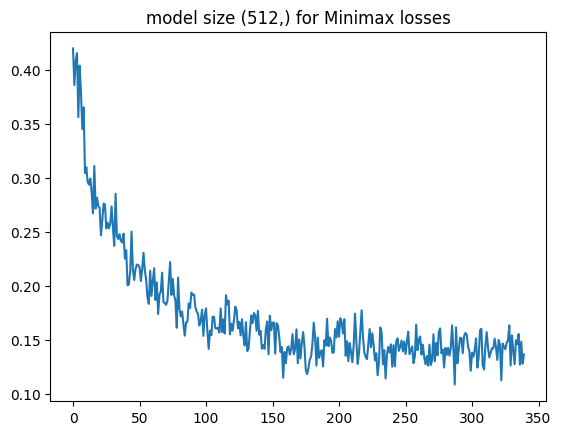

Loading: models/models_('majority',)_uniform_optimize_1/Borda_1_6_10_uniform_('majority',)_1_08-18-2023_09-10-18.pickle


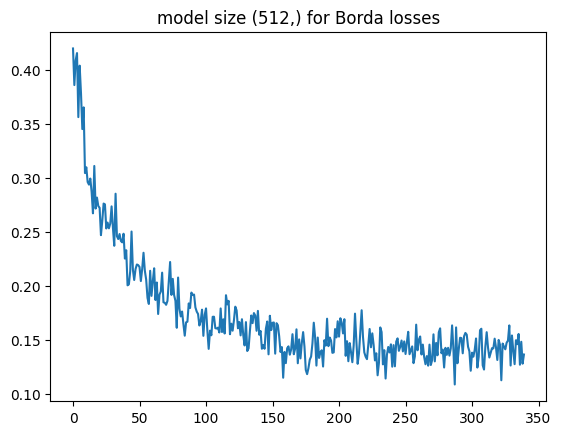

In [10]:
# Select the parameters of the two models to compare

num_cands = 6
num_voters = 10
probmodel = 'uniform'

model_size1 = (512,)
model_size2 = (512,)

vm1 = pref_voting.voting_methods.minimax
vm2 = pref_voting.voting_methods.borda

agent_infos1 = ('majority',)
agent_infos2 = ('majority',)


labeling = 'optimize'
generation = 1
manip_weight = 1

agent1 = get_agent(model_size1, num_cands, num_voters, agent_infos1, vm1, probmodel=probmodel, labeling=labeling, gen=generation, manip_weight=manip_weight, verbose=True)


agent2 = get_agent(model_size2, num_cands, num_voters, agent_infos2, vm2, probmodel=probmodel, labeling=labeling, gen=generation, manip_weight=manip_weight, verbose=True)


In [11]:

num_profiles = 10_000

# generate utility profiles
utility_profiles = generate_utility_profile(
    num_cands, 
    num_voters, 
    probmodel = probmodel, 
    num_profiles = num_profiles
)

# get the utility functions for voter 0 and the linear profiles associated with each utility profile
elections = (
    [uprof.utilities[0] for uprof in utility_profiles],
    [to_linear_prof(uprof) for uprof in utility_profiles],
)

# get the profits and actions for each agent

agent1_evals, agent1_actions = get_profits_actions(
    agent1, 
    len(elections), 
    vm1, 
    num_cands, 
    num_voters, 
    manip_weight, 
    elections, 
    decision_rule='argmax', 
    metric_op="normalized_subtract", 
    agent_infos=agent_infos1)

agent1_evals = agent1_evals.detach().cpu().numpy()
agent1_actions = agent1_actions.detach().cpu().numpy()

agent2_evals, agent2_actions = get_profits_actions(
    agent2, 
    len(elections), 
    vm2, 
    num_cands, 
    num_voters, 
    manip_weight, 
    elections, 
    decision_rule='argmax', 
    metric_op="normalized_subtract", 
    agent_infos=agent_infos2)

agent2_evals = agent2_evals.detach().cpu().numpy()
agent2_actions = agent2_actions.detach().cpu().numpy()


# Compare the profitability of the two agents using the Wilcoxon signed-rank test

Q1 = agent1_evals
Q2 = agent2_evals

# Perform the Wilcoxon signed-rank test (two-sided)
statistic_two_sided, p_value_two_sided = wilcoxon(Q1, Q2)

# Perform the Wilcoxon signed-rank test (one-sided: Q2 > Q1)
statistic_Q2_greater, p_value_Q2_greater = wilcoxon(Q2, Q1, alternative='greater')

print("The average profitability of agent 1 is:", np.mean(Q1))
print(f"Two-sided Wilcoxon signed-rank test statistic: {statistic_two_sided}")
print(f"Two-sided P-value: {p_value_two_sided}")

print("\nThe average profitability of agent 2 is:", np.mean(Q2))
print(f"One-sided Wilcoxon signed-rank test (agent2 profitability > agent1 profitability) statistic: {statistic_Q2_greater}")
print(f"One-sided P-value (agent2 profitability > agent1 profitability): {p_value_Q2_greater}")

# Interpretation
alpha = 0.05  # significance level

# Two-sided test interpretation
if p_value_two_sided < alpha:
   print("\nThere is a statistically significant difference between agent 1 profitability and agent 2 profitability (two-sided test).")
else:
   print("\nThere is no statistically significant difference between agent 1 profitability and agent 2 profitability (two-sided test).")

# One-sided test interpretation for Q2 > Q1
if p_value_Q2_greater < alpha:
   print("There is a statistically significant difference: agent 2 profitability is greater than agent 1 profitability (one-sided test).")
else:
   print("There is no statistically significant difference: agent 2 profitability is not greater than agent 1 profitability (one-sided test).")

The average profitability of agent 1 is: -0.024729311
Two-sided Wilcoxon signed-rank test statistic: 1877861.0
Two-sided P-value: 2.1627929347214273e-225

The average profitability of agent 2 is: 0.038207226
One-sided Wilcoxon signed-rank test (agent2 profitability > agent1 profitability) statistic: 6893905.0
One-sided P-value (agent2 profitability > agent1 profitability): 1.0813964673607137e-225

There is a statistically significant difference between agent 1 profitability and agent 2 profitability (two-sided test).
There is a statistically significant difference: agent 2 profitability is greater than agent 1 profitability (one-sided test).


## Mean Size of the Difference

In [12]:


Q1 = agent1_evals
Q2 = agent2_evals

# Perform the Wilcoxon signed-rank test (two-sided)
statistic_two_sided, p_value_two_sided = wilcoxon(Q1, Q2)

# Calculate mean differences
differences = Q2 - Q1
mean_difference = np.mean(differences)

# Calculate effect size (r)
effect_size = statistic_two_sided / np.sqrt(len(Q1))

# Bootstrap confidence interval for mean difference
def bootstrap_median_diff(Q1, Q2, n_bootstrap=1000):
   differences = Q2 - Q1
   means = []
   for _ in range(n_bootstrap):
       sample_diff = np.random.choice(differences, size=len(differences), replace=True)
       means.append(np.mean(sample_diff))
   return np.percentile(means, [2.5, 97.5])

ci_lower, ci_upper = bootstrap_median_diff(Q1, Q2)

# Print the results
print(f"Two-sided Wilcoxon signed-rank test statistic: {statistic_two_sided}")
print(f"Two-sided P-value: {p_value_two_sided}")
print(f"\nMean of differences (Q2 - Q1): {mean_difference}")
print(f"Effect size (r): {effect_size}")
print(f"95% Confidence Interval for the mean difference: [{ci_lower}, {ci_upper}]")

# Interpretation
alpha = 0.05  # significance level
if p_value_two_sided < alpha:
   print("There is a statistically significant difference between Q1 and Q2.")
else:
   print("There is no statistically significant difference between Q1 and Q2.")

Two-sided Wilcoxon signed-rank test statistic: 1877861.0
Two-sided P-value: 2.1627929347214273e-225

Mean of differences (Q2 - Q1): 0.06293653696775436
Effect size (r): 18778.61
95% Confidence Interval for the mean difference: [0.05911821881309152, 0.06706101186573506]
There is a statistically significant difference between Q1 and Q2.


# Comparing Voting Methods

In this section, you can compare the performance of different voting methods across a range of models.

In [17]:
def comparing_voting_methods(vm1, 
                             vm2, 
                             probmodel, 
                             all_num_cands, 
                             all_num_voters, 
                             all_model_sizes,
                             all_agent_infos):
        num_profiles = 1_000
        alpha = 0.05
        
        labeling = 'optimize'
        generation = 1
        manip_weight = 1

        comparisons = []
        for num_cands in all_num_cands: 
                for num_voters in all_num_voters: 
                        print(f"{num_cands} candidates, {num_voters} voters")
                        for model_size in tqdm(all_model_sizes):
                                for agent_infos in all_agent_infos:
                                        # generate utility profiles
                                        utility_profiles = generate_utility_profile(
                                        num_cands, 
                                        num_voters, 
                                        probmodel = probmodel, 
                                        num_profiles = num_profiles
                                        )

                                        # get the utility functions for voter 0 and the linear profiles associated with each utility profile
                                        elections = (
                                        [uprof.utilities[0] for uprof in utility_profiles],
                                        [to_linear_prof(uprof) for uprof in utility_profiles],
                                        )

                                        agent1 = get_agent(model_size, num_cands, num_voters, agent_infos, vm1, probmodel=probmodel, labeling=labeling, gen=generation, manip_weight=manip_weight)


                                        # get the submitted ranking for each utility profile and the profitability of that submitted ranking.
                                        agent1_evals, agent1_actions = get_profits_actions(
                                        agent1, 
                                        len(elections), 
                                        vm1, 
                                        num_cands, 
                                        num_voters, 
                                        manip_weight, 
                                        elections, 
                                        decision_rule='argmax', 
                                        metric_op="normalized_subtract", 
                                        agent_infos=agent_infos)

                                        agent1_evals = agent1_evals.detach().cpu().numpy()
                                        agent1_actions = agent1_actions.detach().cpu().numpy()

                                        agent2 = get_agent(model_size, num_cands, num_voters, agent_infos, vm2, probmodel=probmodel, labeling=labeling, gen=generation, manip_weight=manip_weight)

                                        agent2_evals, agent2_actions = get_profits_actions(
                                        agent2, 
                                        len(elections), 
                                        vm2, 
                                        num_cands, 
                                        num_voters, 
                                        manip_weight, 
                                        elections, 
                                        decision_rule='argmax', 
                                        metric_op="normalized_subtract", 
                                        agent_infos=agent_infos)

                                        agent2_evals = agent2_evals.detach().cpu().numpy()
                                        agent2_actions = agent2_actions.detach().cpu().numpy()
                                        # Perform the Wilcoxon signed-rank test (one-sided: Q2 > Q1)
                                        statistic_Q2_greater, p_value_Q2_greater = wilcoxon(agent2_evals, agent1_evals, alternative='greater')

                                        comparisons.append(p_value_Q2_greater < alpha)
        return comparisons

In [18]:
probmodel = 'uniform'
all_agent_infos = [
    #('margin',), 
    ('majority',),
    #('sincere_winners',),
    ('plurality_scores',),
    #('plurality_ranking',),
    #('qual_margin',)
    ]
all_num_cands = [6] #[3, 4, 5, 6]
all_num_voters = [10] #[5, 6, 10, 11, 20, 21]
all_model_sizes = [
    (4,), 
    (8,), 
    (16,), 
    (32,), 
    (64,), 
    (128,), 
    (256,), 
    (512,),
    (4, 4), 
    (8, 8), 
    (16, 8), 
    (16, 16), 
    (32, 32), 
    (64, 32), 
    (64, 64), 
    (128, 128), 
    (256, 128), 
    (256, 256),
    (8, 8, 8), 
    (32, 16, 8), 
    (32, 32, 32), 
    (64, 64, 64), 
    (128, 64, 32), 
    (128, 128, 128), 
    (256, 256, 256), 
    (512, 256, 128),
]

vm1 = pref_voting.voting_methods.minimax
vm2 = pref_voting.voting_methods.borda

vm_comparisons = comparing_voting_methods(
    vm1,
    vm2, 
    probmodel, 
    all_num_cands, 
    all_num_voters, 
    all_model_sizes,
    all_agent_infos)

6 candidates, 10 voters


  0%|          | 0/26 [00:00<?, ?it/s]

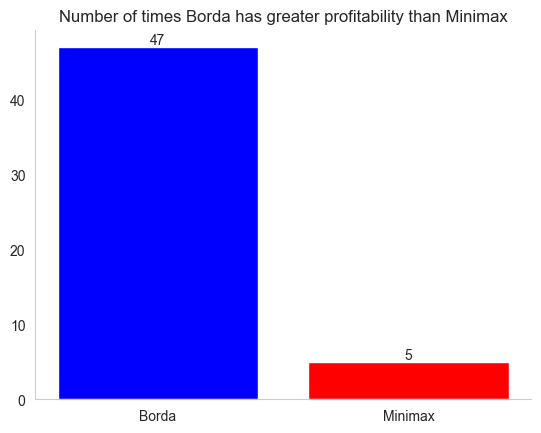

In [23]:
# bar graph of the number of trues and False for vm_comparisons

sns.set_style("whitegrid")
# Counting True and False values
vm2_greater_count = vm_comparisons.count(True)
vm1_greater_count = vm_comparisons.count(False)

# Creating the bar graph
labels = [f'{vm2.name}', f'{vm1.name}']
counts = [vm2_greater_count, vm1_greater_count]

plt.bar(labels, counts, color=['blue', 'red'])

# add the count values on the bars
for i, count in enumerate(counts):
    plt.text(i, count, count, ha='center', va='bottom')
plt.title(f'Number of times {vm2.name} has greater profitability than {vm1.name}')
plt.xlabel('')
plt.ylabel('')
sns.despine()
# remove the grid lines
plt.grid(False)

plt.savefig('vm_comparisons.pdf')
plt.show()


